In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [19]:
DATA_FOLDER = './torch_data/VGAN/MNIST'

def mnist_data():
    compose = transforms.Compose([transforms.ToTensor(),transforms.Normalize((.5,), (.5,))])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

data = mnist_data()
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
num_batches = len(data_loader)
print('num_batches: ',num_batches)

num_batches:  600


(100, 1, 28, 28)


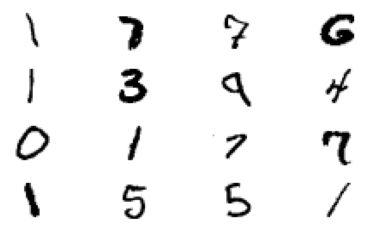

In [20]:
def save_plot(x_input,n=4):
    # x_input = x_input.cpu().detach().numpy()
    x_input = x_input.reshape(x_input.shape[0], x_input.shape[2], x_input.shape[3], x_input.shape[1])
    # plt.subplots(figsize=(20, 10))
    plt.figure(figsize=(7, 4))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        # plt.title(str(lebel[i]),fontsize=10,color="red",fontweight=10,pad='2.0',backgroundcolor='yellow')
        plt.imshow(x_input[i,:,:,0], cmap = 'gray_r')
        plt.axis('off')
    plt.show()
for i,(j,k) in enumerate(data_loader):
  j=j.numpy()
  print(j.shape)
  save_plot(j,n=4)
  break

In [21]:
class DiscriminatorNet(torch.nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
discriminator_temp = DiscriminatorNet()
print(discriminator_temp)

DiscriminatorNet(
  (hidden0): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (out): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [22]:
class GeneratorNet(torch.nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

generator_temp = GeneratorNet()
print(generator_temp)

GeneratorNet(
  (hidden0): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (out): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): Tanh()
  )
)


In [23]:
p = Variable(torch.randn(16, 100))
print(p.size())
k=generator_temp(p)
print(k.size())


torch.Size([16, 100])
torch.Size([16, 784])


In [24]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
# print(torch.cuda.is_available())
if torch.cuda.is_available():
  print('cuda availiable')
  discriminator.cuda()
  generator.cuda()

cuda availiable


In [25]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# if torch.cuda.is_available():
#   loss.cuda()

In [26]:
def save_plot(x_input,n=4):
    # x_input = x_input.cpu().detach().numpy()
    # x_input = x_input.reshape(x_input.shape[0], x_input.shape[2], x_input.shape[3], x_input.shape[1])
    plt.figure(figsize=(7, 4))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        # plt.title(str(lebel[i]),fontsize=10,color="red",fontweight=10,pad='2.0',backgroundcolor='yellow')
        plt.imshow(x_input[i,:,:,0], cmap = 'gray_r')
        plt.axis('off')
    plt.show()
def summarize_the_model(generator, latent_dim = 100):
    latent_points = Variable(torch.randn(16, latent_dim))
    if torch.cuda.is_available():
      latent_points = latent_points.cuda()
    X  = generator(latent_points)
    X  = X.cpu().detach().numpy()   # X  = X.cpu().detach().numpy() 
    X  = X.reshape(16, 28, 28, 1) 
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    save_plot(X, n=4)
    print('*'*150,"\n")

In [27]:
def fake_data_and_target(image, latent_dim=100):
  noise = Variable(torch.randn(image.size(0), latent_dim))
  target = Variable(torch.zeros(image.size(0), 1))
  if torch.cuda.is_available():
    noise = noise.cuda()
    target = target.cuda()
  return noise, target

def real_data_and_target(image):
  real = Variable(image)
  target = Variable(torch.ones(image.size(0), 1))
  if torch.cuda.is_available():
    real=real.cuda()
    target=target.cuda()
  return real,target

In [28]:
for n_batch, (real_batch,_) in enumerate(data_loader):
  a,b = fake_data_and_target(real_batch, latent_dim=100)
  print('fake: ',a.size(),b.size())
  c,d =  real_data_and_target(real_batch)
  print('real: ',c.size(),d.size())
  break

fake:  torch.Size([100, 100]) torch.Size([100, 1])
real:  torch.Size([100, 1, 28, 28]) torch.Size([100, 1])


In [29]:
def train(data, discriminator, generator, d_optimizer, g_optimizer, loss,  epochs=15):
  for epoch in range(epochs):
    d_error_total, g_error_total = 0.0, 0.0
    for n_batch, (real_batch,_) in enumerate(data):

      # ******************************************************************************************************
      # discriminator
      d_optimizer.zero_grad()

      ## real
      # print(real_batch.size())
      real_batch = real_batch.view(real_batch.size(0), 784)
      # print(real_batch.size())
      real_data, real_target =  real_data_and_target(real_batch)
      # print('real_data: ', real_data.size(), 'real_target: ', real_target.size())

      r_predicted_target = discriminator(real_data)
      r_error = loss(r_predicted_target, real_target)
      r_error.backward()

      ## fake
      fake_data, fake_target =  fake_data_and_target(real_batch)
      # print('fake_data: ', fake_data.size(), 'fake_target: ', fake_target.size())

      noise_data = generator(fake_data).detach()
      f_predicted_target = discriminator(noise_data)
      f_error = loss(f_predicted_target, fake_target)
      f_error.backward()

      d_error_temp = (r_error.item()+f_error.item())
      # d_error_temp.backward()

      d_optimizer.step()

      d_error_total += d_error_temp

      # *******************************************************************************************************
      # generator
      g_optimizer.zero_grad()

      ## fake
      g_fake_data, g_fake_target =  fake_data_and_target(real_batch)

      g_noise_data = generator(g_fake_data)
      g_predicted_target = discriminator(g_noise_data)
      g_error = loss(g_predicted_target, real_target)
      g_error.backward()

      g_optimizer.step()

      g_error_total += g_error.item()
      # print('d_error: ', d_error_temp.item(), '        g_error: ', g_error.item())
      # break
    print('epoch -> [%d/%d], d_loss = %.2f, g_loss = %.2f' %(epoch+1, epochs, d_error_total, g_error_total))
    # break
    summarize_the_model(generator)

epoch -> [1/100], d_loss = 689.67, g_loss = 669.34


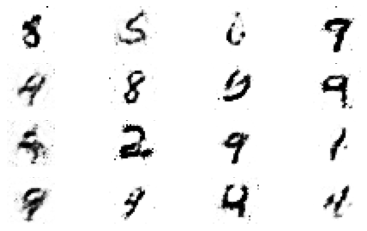

****************************************************************************************************************************************************** 

epoch -> [2/100], d_loss = 692.34, g_loss = 674.17


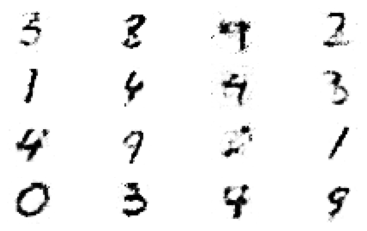

****************************************************************************************************************************************************** 

epoch -> [3/100], d_loss = 687.42, g_loss = 675.11


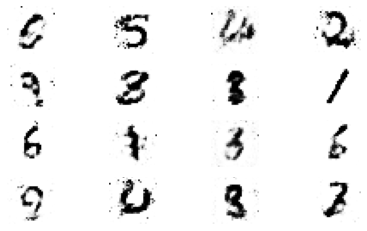

****************************************************************************************************************************************************** 

epoch -> [4/100], d_loss = 690.38, g_loss = 680.02


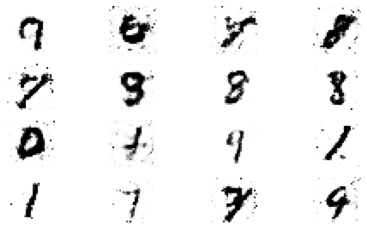

****************************************************************************************************************************************************** 

epoch -> [5/100], d_loss = 688.49, g_loss = 661.84


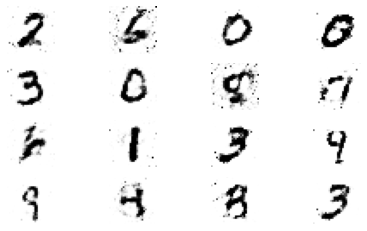

****************************************************************************************************************************************************** 

epoch -> [6/100], d_loss = 691.82, g_loss = 662.14


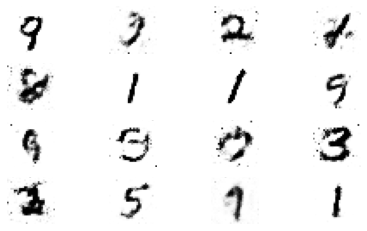

****************************************************************************************************************************************************** 

epoch -> [7/100], d_loss = 695.07, g_loss = 674.39


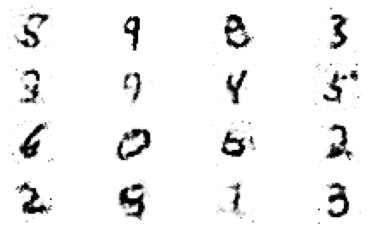

****************************************************************************************************************************************************** 

epoch -> [8/100], d_loss = 690.52, g_loss = 673.75


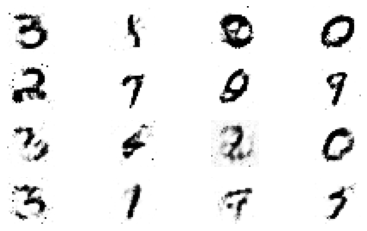

****************************************************************************************************************************************************** 

epoch -> [9/100], d_loss = 690.01, g_loss = 671.55


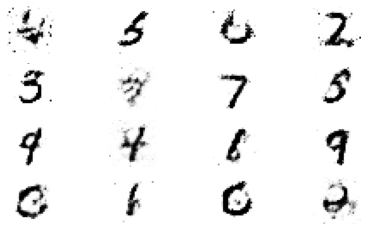

****************************************************************************************************************************************************** 

epoch -> [10/100], d_loss = 696.58, g_loss = 659.07


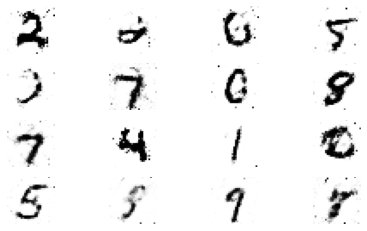

****************************************************************************************************************************************************** 

epoch -> [11/100], d_loss = 700.98, g_loss = 650.77


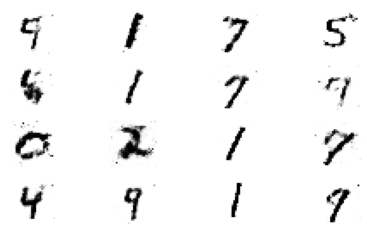

****************************************************************************************************************************************************** 

epoch -> [12/100], d_loss = 706.04, g_loss = 641.78


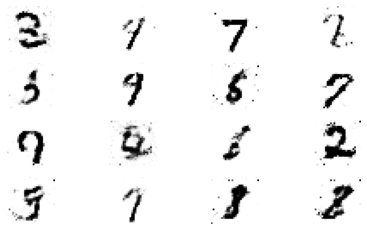

****************************************************************************************************************************************************** 

epoch -> [13/100], d_loss = 704.42, g_loss = 643.55


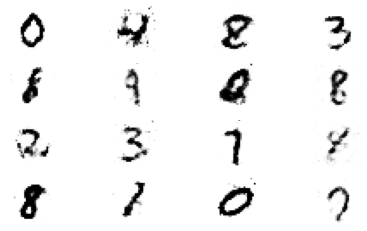

****************************************************************************************************************************************************** 

epoch -> [14/100], d_loss = 709.37, g_loss = 636.80


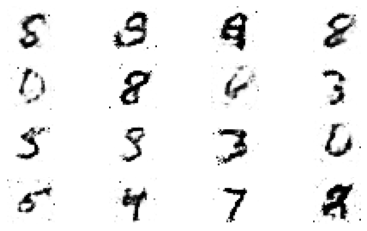

****************************************************************************************************************************************************** 

epoch -> [15/100], d_loss = 709.10, g_loss = 637.96


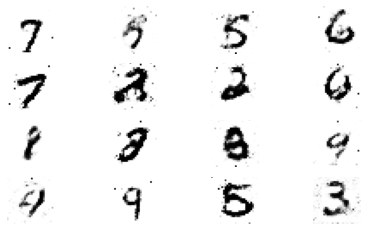

****************************************************************************************************************************************************** 

epoch -> [16/100], d_loss = 708.69, g_loss = 635.11


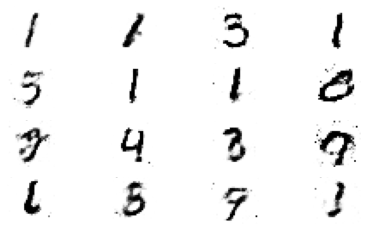

****************************************************************************************************************************************************** 

epoch -> [17/100], d_loss = 722.28, g_loss = 610.86


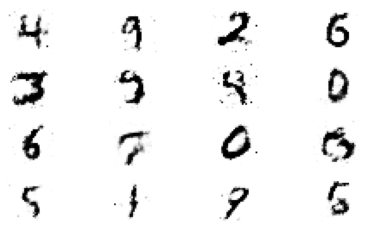

****************************************************************************************************************************************************** 

epoch -> [18/100], d_loss = 717.38, g_loss = 619.27


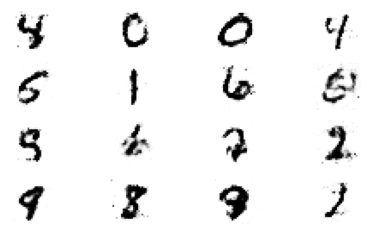

****************************************************************************************************************************************************** 

epoch -> [19/100], d_loss = 717.68, g_loss = 619.65


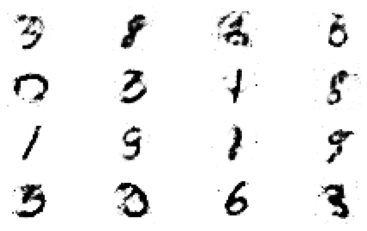

****************************************************************************************************************************************************** 

epoch -> [20/100], d_loss = 721.10, g_loss = 612.55


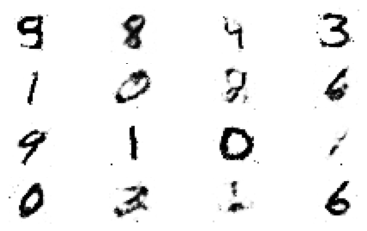

****************************************************************************************************************************************************** 

epoch -> [21/100], d_loss = 726.84, g_loss = 610.42


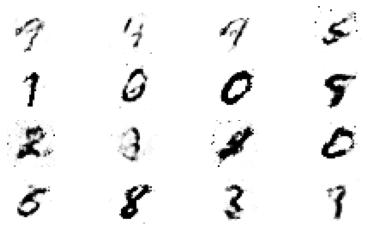

****************************************************************************************************************************************************** 

epoch -> [22/100], d_loss = 724.73, g_loss = 608.92


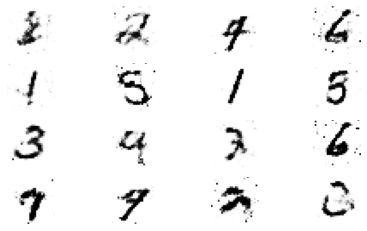

****************************************************************************************************************************************************** 

epoch -> [23/100], d_loss = 726.74, g_loss = 605.42


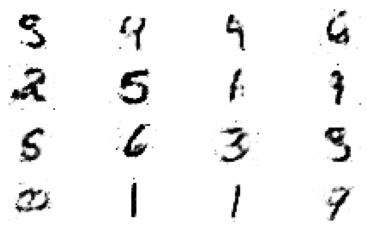

****************************************************************************************************************************************************** 

epoch -> [24/100], d_loss = 729.87, g_loss = 604.28


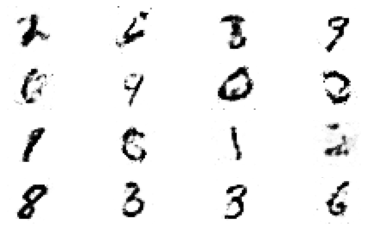

****************************************************************************************************************************************************** 

epoch -> [25/100], d_loss = 731.28, g_loss = 605.44


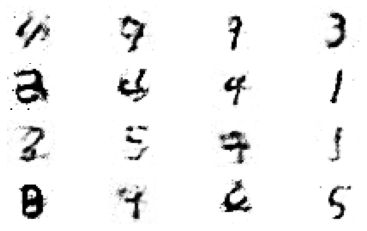

****************************************************************************************************************************************************** 

epoch -> [26/100], d_loss = 731.27, g_loss = 596.89


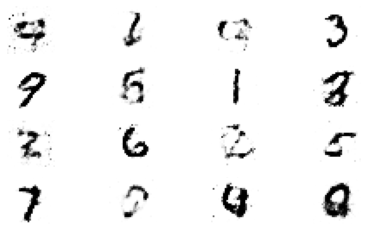

****************************************************************************************************************************************************** 

epoch -> [27/100], d_loss = 728.72, g_loss = 602.83


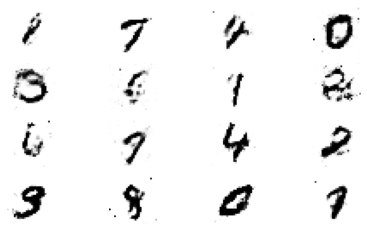

****************************************************************************************************************************************************** 

epoch -> [28/100], d_loss = 727.09, g_loss = 606.41


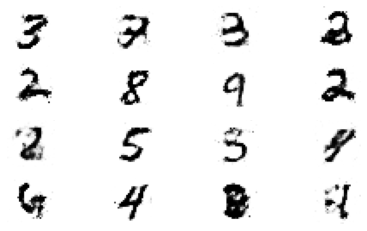

****************************************************************************************************************************************************** 

epoch -> [29/100], d_loss = 734.39, g_loss = 589.24


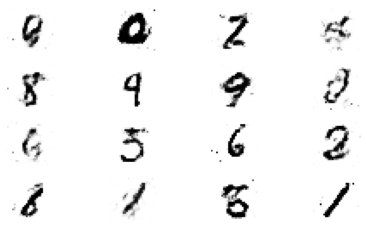

****************************************************************************************************************************************************** 

epoch -> [30/100], d_loss = 732.06, g_loss = 602.83


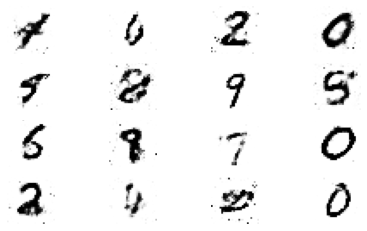

****************************************************************************************************************************************************** 

epoch -> [31/100], d_loss = 732.77, g_loss = 599.10


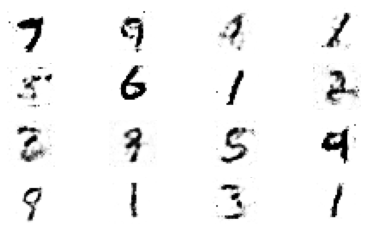

****************************************************************************************************************************************************** 

epoch -> [32/100], d_loss = 735.11, g_loss = 592.10


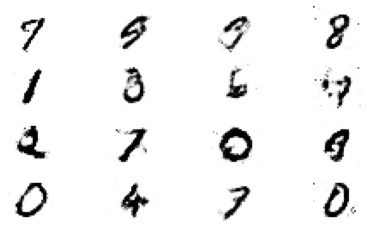

****************************************************************************************************************************************************** 

epoch -> [33/100], d_loss = 737.15, g_loss = 584.48


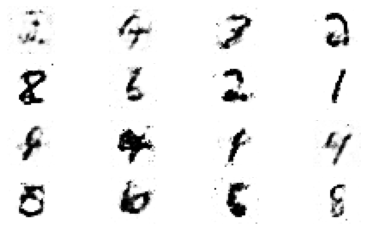

****************************************************************************************************************************************************** 

epoch -> [34/100], d_loss = 739.35, g_loss = 586.96


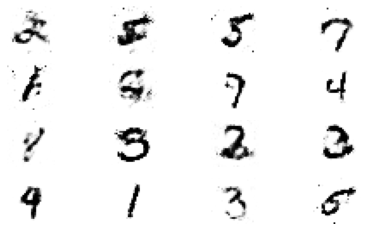

****************************************************************************************************************************************************** 

epoch -> [35/100], d_loss = 739.40, g_loss = 586.47


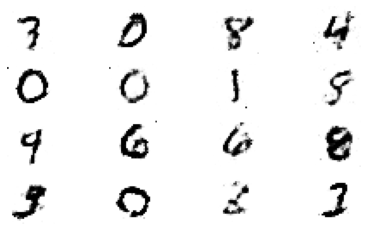

****************************************************************************************************************************************************** 

epoch -> [36/100], d_loss = 737.80, g_loss = 594.08


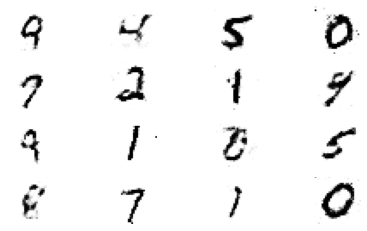

****************************************************************************************************************************************************** 

epoch -> [37/100], d_loss = 736.45, g_loss = 592.27


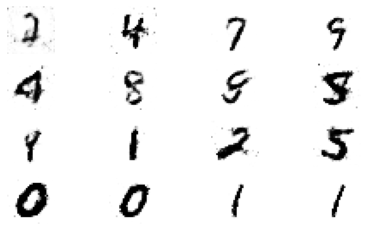

****************************************************************************************************************************************************** 

epoch -> [38/100], d_loss = 741.80, g_loss = 577.39


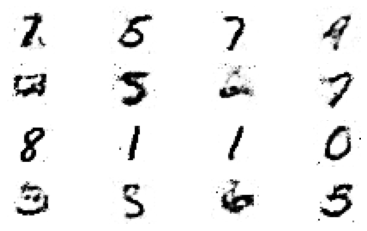

****************************************************************************************************************************************************** 

epoch -> [39/100], d_loss = 744.19, g_loss = 579.19


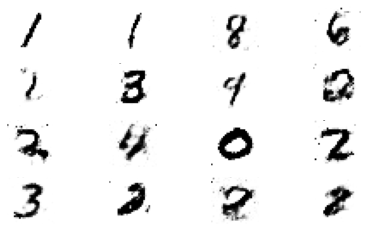

****************************************************************************************************************************************************** 

epoch -> [40/100], d_loss = 747.28, g_loss = 571.29


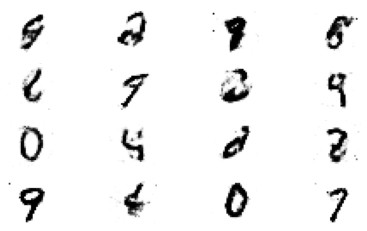

****************************************************************************************************************************************************** 

epoch -> [41/100], d_loss = 746.41, g_loss = 573.25


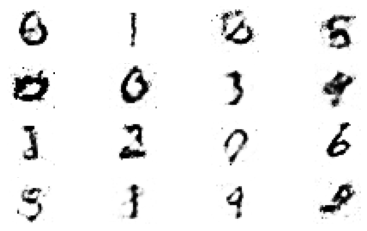

****************************************************************************************************************************************************** 

epoch -> [42/100], d_loss = 747.68, g_loss = 571.12


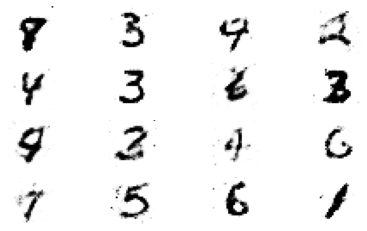

****************************************************************************************************************************************************** 

epoch -> [43/100], d_loss = 740.80, g_loss = 590.91


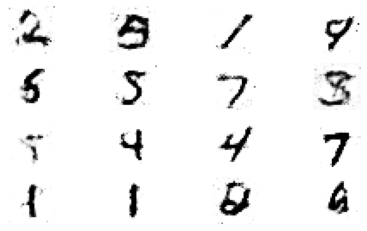

****************************************************************************************************************************************************** 

epoch -> [44/100], d_loss = 743.01, g_loss = 570.23


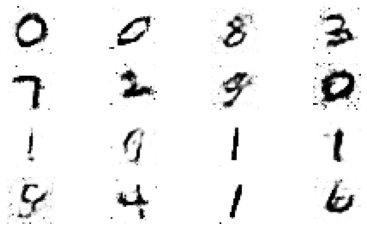

****************************************************************************************************************************************************** 

epoch -> [45/100], d_loss = 747.16, g_loss = 571.71


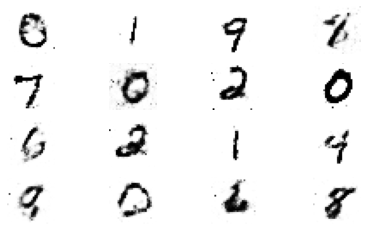

****************************************************************************************************************************************************** 

epoch -> [46/100], d_loss = 740.13, g_loss = 585.24


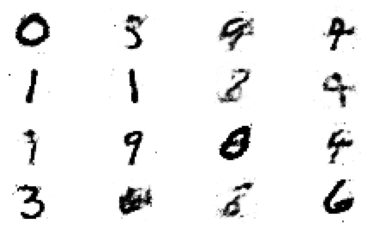

****************************************************************************************************************************************************** 

epoch -> [47/100], d_loss = 744.91, g_loss = 578.98


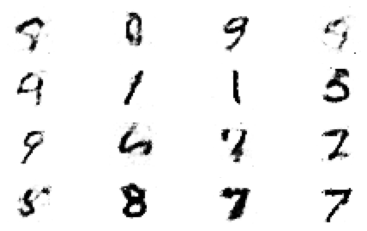

****************************************************************************************************************************************************** 

epoch -> [48/100], d_loss = 742.08, g_loss = 581.77


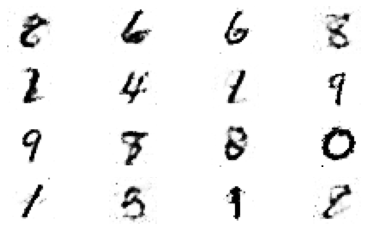

****************************************************************************************************************************************************** 

epoch -> [49/100], d_loss = 741.10, g_loss = 574.58


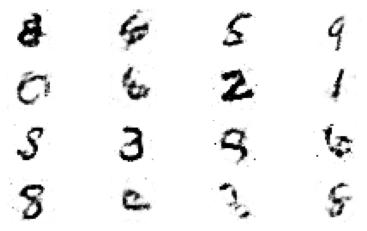

****************************************************************************************************************************************************** 

epoch -> [50/100], d_loss = 745.05, g_loss = 573.80


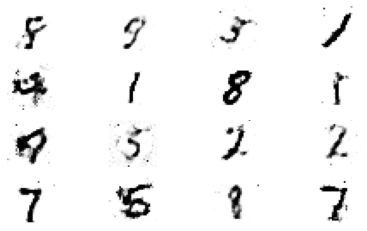

****************************************************************************************************************************************************** 

epoch -> [51/100], d_loss = 743.98, g_loss = 582.16


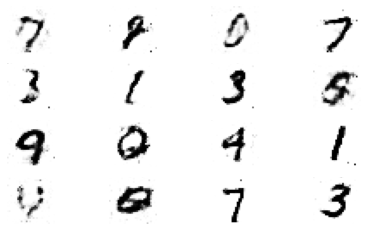

****************************************************************************************************************************************************** 

epoch -> [52/100], d_loss = 746.72, g_loss = 569.80


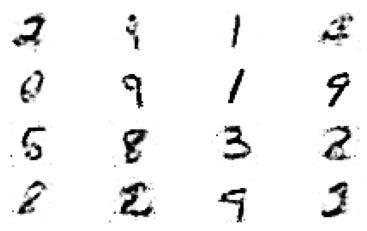

****************************************************************************************************************************************************** 

epoch -> [53/100], d_loss = 749.24, g_loss = 568.27


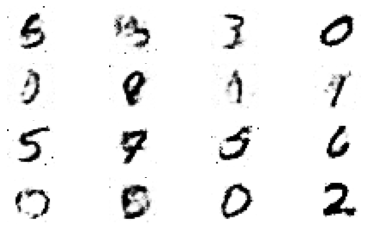

****************************************************************************************************************************************************** 

epoch -> [54/100], d_loss = 745.77, g_loss = 570.51


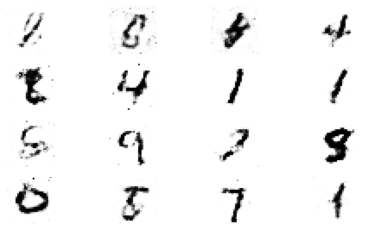

****************************************************************************************************************************************************** 

epoch -> [55/100], d_loss = 747.05, g_loss = 567.27


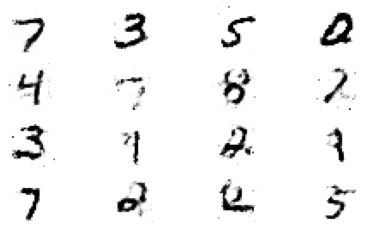

****************************************************************************************************************************************************** 

epoch -> [56/100], d_loss = 754.65, g_loss = 560.38


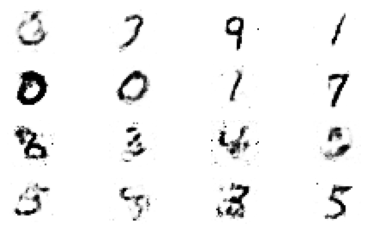

****************************************************************************************************************************************************** 

epoch -> [57/100], d_loss = 752.57, g_loss = 564.81


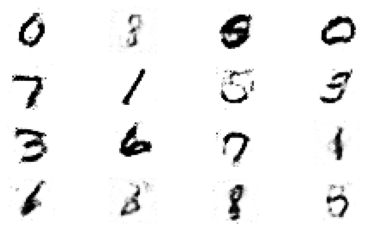

****************************************************************************************************************************************************** 

epoch -> [58/100], d_loss = 747.85, g_loss = 563.15


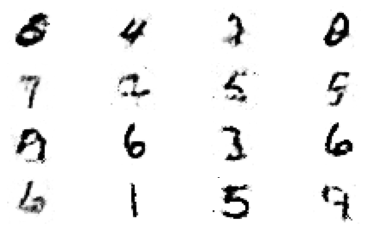

****************************************************************************************************************************************************** 

epoch -> [59/100], d_loss = 753.60, g_loss = 560.02


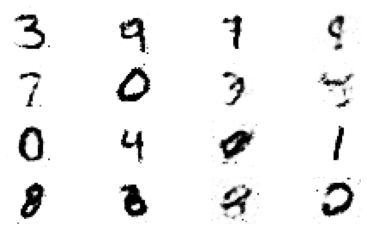

****************************************************************************************************************************************************** 

epoch -> [60/100], d_loss = 751.75, g_loss = 565.94


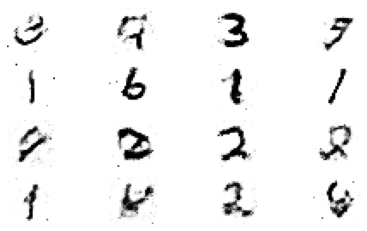

****************************************************************************************************************************************************** 

epoch -> [61/100], d_loss = 750.00, g_loss = 560.25


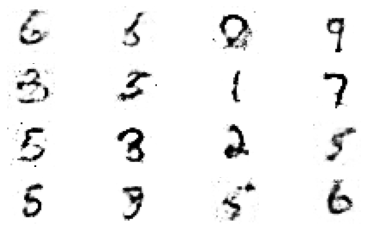

****************************************************************************************************************************************************** 

epoch -> [62/100], d_loss = 748.93, g_loss = 571.01


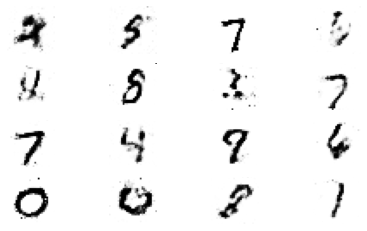

****************************************************************************************************************************************************** 

epoch -> [63/100], d_loss = 752.85, g_loss = 559.35


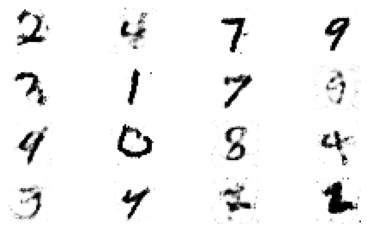

****************************************************************************************************************************************************** 

epoch -> [64/100], d_loss = 749.15, g_loss = 573.56


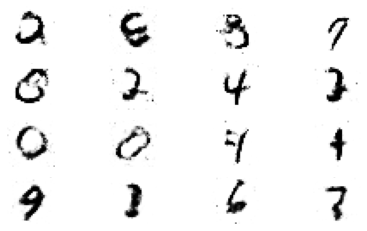

****************************************************************************************************************************************************** 

epoch -> [65/100], d_loss = 748.58, g_loss = 567.89


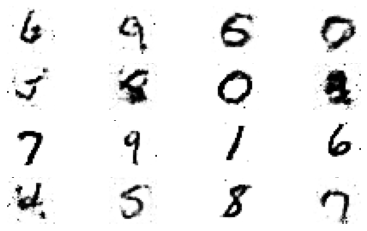

****************************************************************************************************************************************************** 

epoch -> [66/100], d_loss = 751.72, g_loss = 572.97


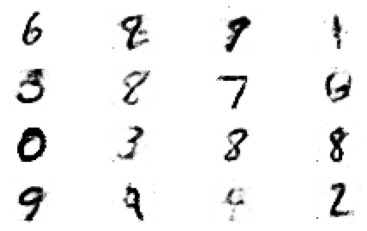

****************************************************************************************************************************************************** 

epoch -> [67/100], d_loss = 752.11, g_loss = 563.00


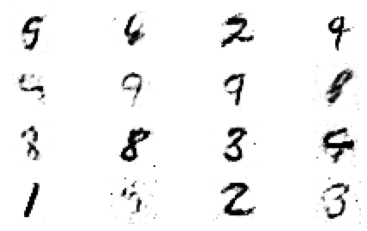

****************************************************************************************************************************************************** 

epoch -> [68/100], d_loss = 749.89, g_loss = 572.93


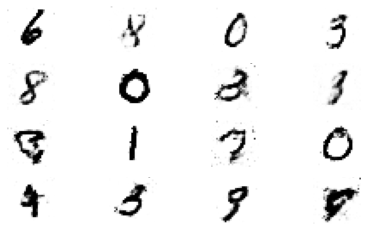

****************************************************************************************************************************************************** 

epoch -> [69/100], d_loss = 752.25, g_loss = 562.70


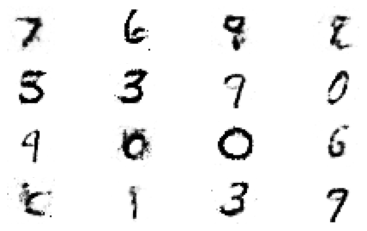

****************************************************************************************************************************************************** 

epoch -> [70/100], d_loss = 753.94, g_loss = 559.11


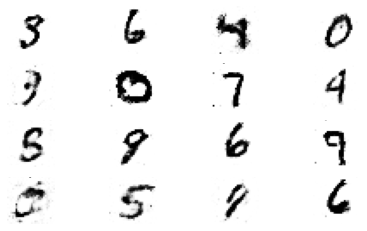

****************************************************************************************************************************************************** 

epoch -> [71/100], d_loss = 753.64, g_loss = 560.39


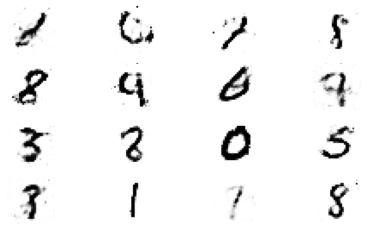

****************************************************************************************************************************************************** 

epoch -> [72/100], d_loss = 748.68, g_loss = 571.37


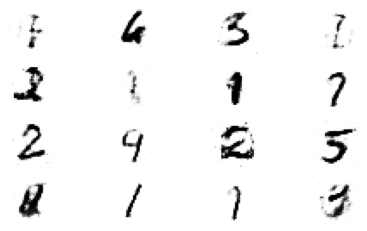

****************************************************************************************************************************************************** 

epoch -> [73/100], d_loss = 750.92, g_loss = 558.81


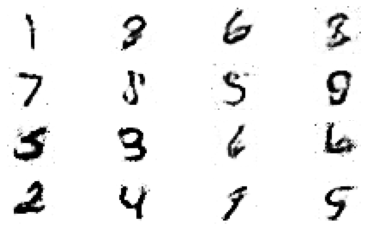

****************************************************************************************************************************************************** 

epoch -> [74/100], d_loss = 755.45, g_loss = 559.87


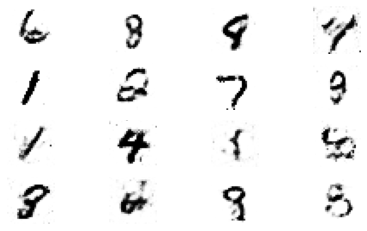

****************************************************************************************************************************************************** 

epoch -> [75/100], d_loss = 754.50, g_loss = 556.63


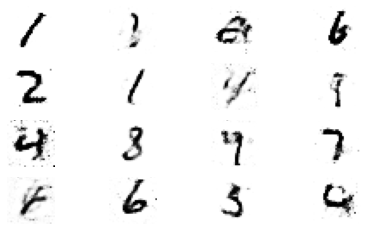

****************************************************************************************************************************************************** 

epoch -> [76/100], d_loss = 756.14, g_loss = 550.58


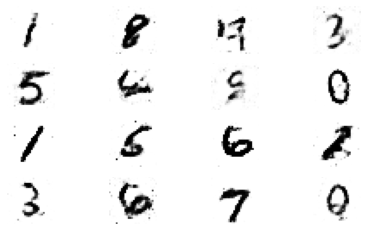

****************************************************************************************************************************************************** 

epoch -> [77/100], d_loss = 756.02, g_loss = 553.24


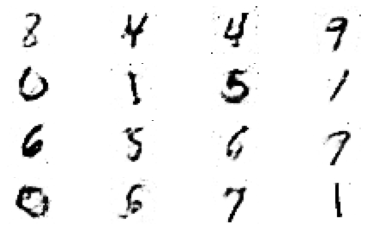

****************************************************************************************************************************************************** 

epoch -> [78/100], d_loss = 760.72, g_loss = 549.86


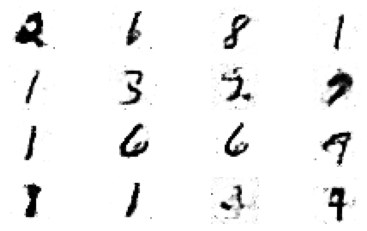

****************************************************************************************************************************************************** 

epoch -> [79/100], d_loss = 753.58, g_loss = 558.46


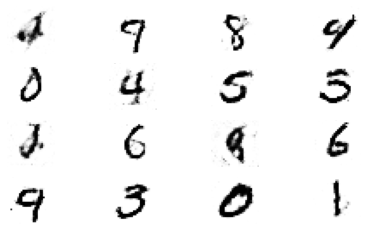

****************************************************************************************************************************************************** 

epoch -> [80/100], d_loss = 757.90, g_loss = 553.55


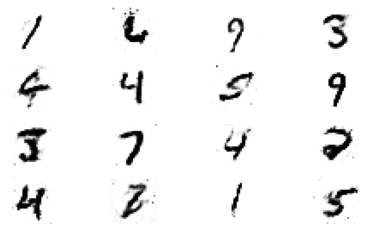

****************************************************************************************************************************************************** 

epoch -> [81/100], d_loss = 757.67, g_loss = 551.87


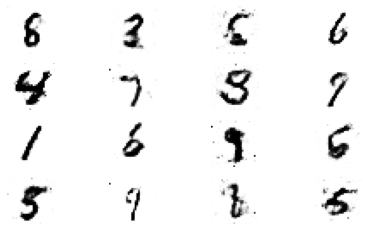

****************************************************************************************************************************************************** 

epoch -> [82/100], d_loss = 758.39, g_loss = 548.11


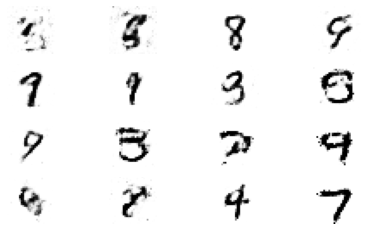

****************************************************************************************************************************************************** 

epoch -> [83/100], d_loss = 756.85, g_loss = 555.12


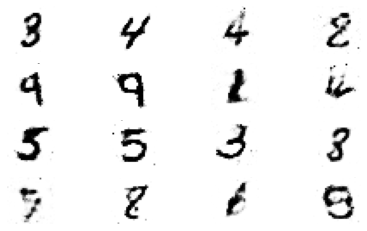

****************************************************************************************************************************************************** 

epoch -> [84/100], d_loss = 756.27, g_loss = 555.59


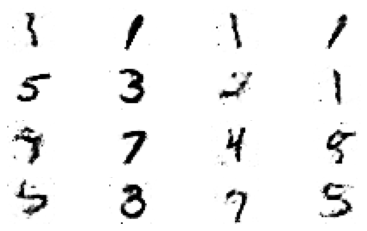

****************************************************************************************************************************************************** 

epoch -> [85/100], d_loss = 756.63, g_loss = 557.40


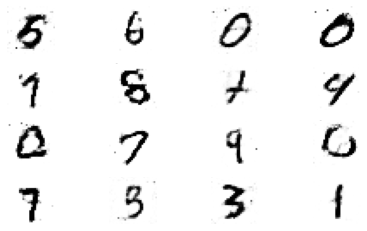

****************************************************************************************************************************************************** 

epoch -> [86/100], d_loss = 756.85, g_loss = 552.16


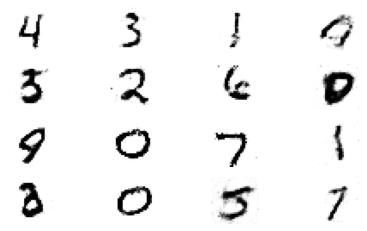

****************************************************************************************************************************************************** 

epoch -> [87/100], d_loss = 761.71, g_loss = 545.75


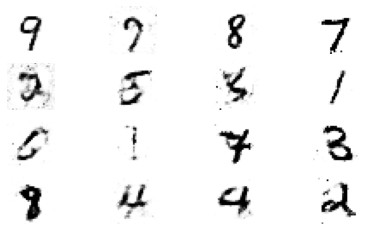

****************************************************************************************************************************************************** 

epoch -> [88/100], d_loss = 758.11, g_loss = 556.08


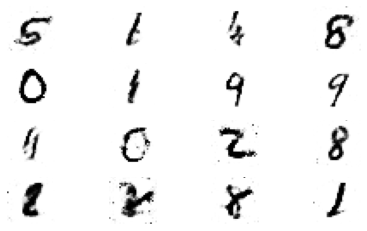

****************************************************************************************************************************************************** 

epoch -> [89/100], d_loss = 759.74, g_loss = 549.66


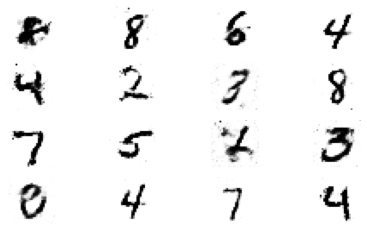

****************************************************************************************************************************************************** 

epoch -> [90/100], d_loss = 761.47, g_loss = 539.95


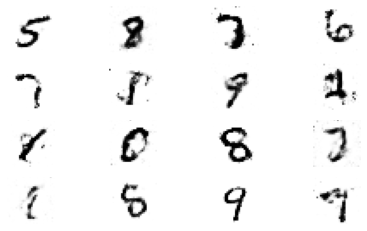

****************************************************************************************************************************************************** 

epoch -> [91/100], d_loss = 764.07, g_loss = 545.95


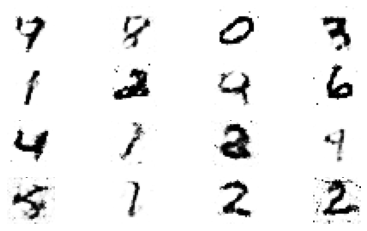

****************************************************************************************************************************************************** 

epoch -> [92/100], d_loss = 757.85, g_loss = 551.73


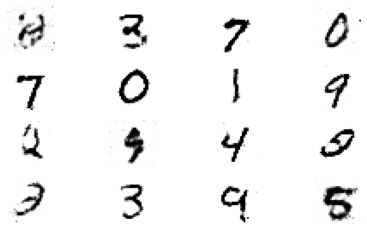

****************************************************************************************************************************************************** 

epoch -> [93/100], d_loss = 760.02, g_loss = 546.67


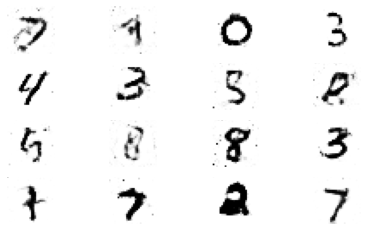

****************************************************************************************************************************************************** 

epoch -> [94/100], d_loss = 759.37, g_loss = 551.02


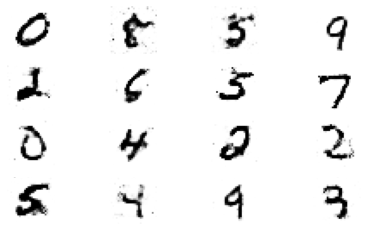

****************************************************************************************************************************************************** 

epoch -> [95/100], d_loss = 761.18, g_loss = 542.93


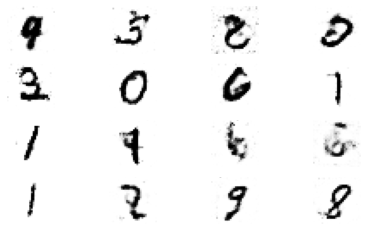

****************************************************************************************************************************************************** 

epoch -> [96/100], d_loss = 759.96, g_loss = 545.76


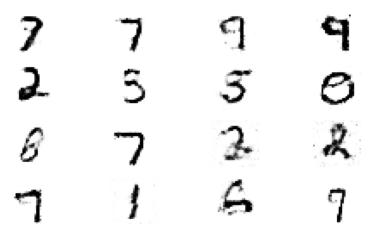

****************************************************************************************************************************************************** 

epoch -> [97/100], d_loss = 761.57, g_loss = 548.24


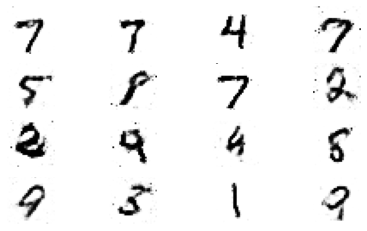

****************************************************************************************************************************************************** 

epoch -> [98/100], d_loss = 761.11, g_loss = 541.14


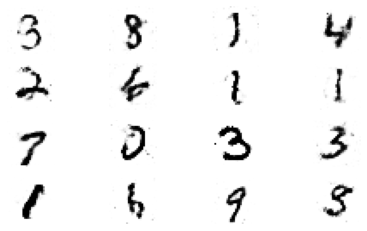

****************************************************************************************************************************************************** 

epoch -> [99/100], d_loss = 763.29, g_loss = 538.74


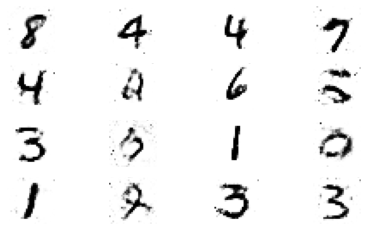

****************************************************************************************************************************************************** 

epoch -> [100/100], d_loss = 765.28, g_loss = 541.14


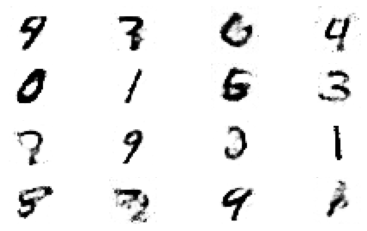

****************************************************************************************************************************************************** 



In [32]:
train(data_loader, discriminator, generator, d_optimizer, g_optimizer, loss,  epochs=100)